# Predicting Road Traffic Accident Severity in London Using Machine Learning and Spatial Network Features

In [11]:
%load_ext watermark
%watermark -a "Yifan Wu" -u -d -t -v -p numpy,pandas,matplotlib,scikit-learn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Yifan Wu

Last updated: 2025-04-21 02:17:53

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

numpy       : 2.2.4
pandas      : 2.2.3
matplotlib  : 3.10.1
scikit-learn: 1.6.1



## Preparation

- [Github link](https://github.com/Van-Wu1/0006.git)

- Number of words: 1463

- Runtime: about 1 hour (*Memory 32 GB, CPU AMD Ryzen 7 5800H with Radeon Graphics CPU @3.20GHz*)

- Coding environment: Coding environment: VS Code with Jupyter plugin (local), not SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.(used to print Python and package versions for reproducibility.)
    - **osmnx**: For downloading and analyzing OpenStreetMap road network data.
    - **networkx**: For calculating road network metrics such as betweenness and degree centrality.
    - **geopandas**: For spatial data handling, including reading GeoJSON borough boundaries.
    - **shap**: For model interpretability using SHAP value analysis.
    - **xgboost**: For gradient boosting machine learning classification.
    - **tqdm**: For displaying progress bars during borough-level computations.


## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Road traffic accidents (RTAs) pose major challenges to public health and urban governance. In the UK, thousands are injured or killed annually, despite improvements in vehicle technology and traffic enforcement. Accurate prediction of accident severity is vital for targeted interventions and infrastructure planning. Severity outcomes are influenced by contextual factors such as weather, road geometry, traffic volume, time of day, and infrastructure design (Abdel-Aty & Haleem, 2011). With the shift toward data-driven governance, machine learning has become a valuable tool in road safety research, offering more nuanced and interpretable models (Ahmed et al., 2023).

Recent studies have validated the use of supervised learning algorithms like logistic regression, random forests, and XGBoost in predicting accident severity from structured datasets. These models handle non-linear and heterogeneous relationships well. Additionally, explainable AI methods such as SHAP (SHapley Additive exPlanations) allow interpretation of feature importance, aiding the translation of model insights into policy actions.

This study uses the UK Department for Transport’s Road Safety Data (2015–2019), enriched with spatial metrics like road betweenness and degree centrality derived from OpenStreetMap. The goal is to assess machine learning performance in predicting severity and to explore the relative contributions of spatial and contextual factors.

The 2015–2019 period ensures data stability, avoiding disruptions from the COVID-19 pandemic and major infrastructure shifts starting in 2020 (DfT, 2021; TfL, 2024). Unlike earlier policy-introduction phases (DfT, 2013), this timeframe reflects mature system conditions, allowing for clearer interpretation.

By integrating spatial topology with traditional features, this project bridges predictive modeling and network analysis, enhancing our understanding of how urban structure affects accident severity.

## Research questions

[[ go back to the top ]](#Table-of-contents)

Can supervised machine learning models accurately predict the severity of road traffic accidents in London using spatial, temporal, and environmental features?

This project explores whether supervised machine learning models can accurately predict the severity of road traffic accidents in London based on spatial, temporal, and environmental features. Specifically, it evaluates the contribution of variables such as time of day, weather conditions, and road network centrality. The study compares the performance of Logistic Regression, Random Forest, and XGBoost classifiers, and employs SHAP (SHapley Additive exPlanations) to interpret model outputs and quantify feature importance across different severity levels (fatal, serious, slight).

## Data

[[ go back to the top ]](#Table-of-contents)

### Data Description

| Variable                          | Type         | Description                                                | Notes                                 |
|-----------------------------------|--------------|------------------------------------------------------------|----------------------------------------|
| accident_severity               | Categorical  | Severity level (1 = Fatal, 2 = Serious, 3 = Slight)         | Target variable                        |
| speed_limit`                     | Numeric      | Speed limit of the road segment (mph)                      | –                                      |
| accident_year`                   | Numeric      | Year of the accident                                        | Used for train-test split              |
| mean_betweenness / max_betweenness | Numeric  | Betweenness centrality of road network                     | Spatial network feature                |
| mean_degree / max_degree     | Numeric      | Degree centrality of network nodes                         | –                                      |
| edge_count                      | Numeric      | Number of nearby road edges                                | Indicator of network density           |
| time_hour                       | Numeric      | Hour of the accident (0–23)                                | Derived feature                        |
| *_encoded categorical features  | Categorical  | One-hot encoded variables: day, weather, road type, etc.   | One-hot encoded                        |
| betweenness_level_encoded      | Ordinal      | Quartile level of mean betweenness (0 = Low, 3 = High)     | For logistic regression compatibility  |
| ......  | ......  | ......                                    |   |

> *Note: *_encoded includes all one-hot encoded features (e.g., weather, light, junction type, road class, area type).*


The following table provides code-level descriptions for categorical variables used in this study. Definitions are based on the official UK Department for Transport data guide: [data.gov.uk](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f).

| Variable Prefix                         | Code | Meaning                                   |
|----------------------------------------|------|-------------------------------------------|
| day_of_week                            | 1    | Sunday                                    |
|                                        | 2    | Monday                                    |
|                                        | 3    | Tuesday                                   |
|                                        | 4    | Wednesday                                 |
|                                        | 5    | Thursday                                  |
|                                        | 6    | Friday                                    |
|                                        | 7    | Saturday                                  |
| road_type                              | 1    | Roundabout                                |
|                                        | 2    | One way street                            |
|                                        | 3    | Dual carriageway                          |
|                                        | 6    | Single carriageway                        |
|                                        | 7    | Slip road                                  |
|                                        | 9    | Unknown                                   |
| light_conditions                       | 1    | Daylight                                   |
|                                        | 4    | Darkness - lights lit                      |
|                                        | 5    | Darkness - lights unlit                    |
|                                        | 6    | Darkness - no lighting                     |
|                                        | 7    | Darkness - lighting unknown                |
| weather_conditions                     | 1    | Fine no high winds                         |
|                                        | 2    | Raining no high winds                      |
|                                        | 3    | Snowing no high winds                      |
|                                        | 4    | Fine + high winds                          |
|                                        | 5    | Raining + high winds                       |
|                                        | 6    | Snowing + high winds                       |
|                                        | 7    | Fog or mist                                |
|                                        | 8    | Other                                      |
|                                        | 9    | Unknown                                    |
| road_surface_conditions                | 1    | Dry                                        |
|                                        | 2    | Wet or damp                                |
|                                        | 3    | Snow                                       |
|                                        | 4    | Frost or ice                               |
|                                        | 5    | Flood (surface water)                      |
|                                        | 9    | Unknown                                    |
| junction_control                       | 0    | None                                       |
|                                        | 1    | Authorised person                          |
|                                        | 2    | Auto traffic signal                        |
|                                        | 3    | Stop sign                                  |
|                                        | 4    | Give way or uncontrolled                   |
|                                        | 9    | Unknown                                    |
| pedestrian_crossing_human_control      | 0    | None                                       |
|                                        | 1    | School crossing patrol                     |
|                                        | 2    | Other human control                        |
|                                        | 9    | Unknown                                    |
| pedestrian_crossing_physical_facilities| 0    | None                                       |
|                                        | 1    | Zebra crossing                             |
|                                        | 4    | Pelican crossing                           |
|                                        | 5    | Footbridge or subway                       |
|                                        | 7    | Refuge                                     |
|                                        | 8    | Unknown                                     |
|                                        | 9    | Other                                      |
| urban_or_rural_area                    | 1    | Not used                                   |
|                                        | 2    | Urban                                      |
|                                        | 3    | Rural                                      |
| trunk_road_flag                        | 1    | Non-trunk road                             |
|                                        | 2    | Trunk road                                 |
| first_road_class / second_road_class   | 1    | Motorway                                   |
|                                        | 2    | A(M) Road                                   |
|                                        | 3    | A Road                                     |
|                                        | 4    | B Road                                     |
|                                        | 5    | C Road                                     |
|                                        | 6    | Unclassified                               |


### Data Import & Cleaning

In [4]:
# It would import the packages that would be used first. 
import pandas as pd
import os
import osmnx as ox
import networkx as nx
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import re
from collections import defaultdict
import shap

e:\Software\Study\python-3.13.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define folder
input_folder = '../data/raw'
output_folder = '../data/clean'

In [12]:
# Road Data
df = pd.read_csv('../data/raw/dft-road-casualty-statistics-collision-1979-latest-published-year.csv')
df = df[df['accident_year'].isin([2015, 2016, 2017, 2018, 2019])]
print(f"The data volume from 2015 to 2019 is:{len(df)} ")

# save
df.to_csv("../data/raw/2015_2019.csv", index=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23812\2199723819.py:2: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/dft-road-casualty-statistics-collision-1979-latest-published-year.csv')


The data volume from 2015 to 2019 is:646830 


In [5]:
columns_to_keep = [
    'accident_severity',
    'number_of_vehicles',
    'number_of_casualties',
    'day_of_week',
    'time',
    'first_road_class',
    'second_road_class',
    'road_type',
    'speed_limit',
    'junction_detail',
    'junction_control',
    'pedestrian_crossing_human_control',
    'pedestrian_crossing_physical_facilities',
    'light_conditions',
    'weather_conditions',
    'road_surface_conditions',
    'special_conditions_at_site',
    'carriageway_hazards',
    'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident',
    'trunk_road_flag',
    'local_authority_ons_district',
    'accident_year'
]

selected_columns = [col for col in columns_to_keep if col in df.columns]
df_cleaned = df[selected_columns]

# Check and handle the missing values
missing_counts = df_cleaned.isnull().sum()
total_missing = missing_counts.sum()

if total_missing > 0:
    print(f"The number of missing values are {total_missing} :")
    print(missing_counts[missing_counts > 0])
    
    # Discard the rows containing missing values
    df_cleaned = df_cleaned.dropna()
    print(f"Missing values have been cleared, remaining {len(df_cleaned)} records.")

# Save the cleaned files
df_cleaned.to_csv('../data/clean/1519_cleaned.csv', index=False)
print(f"Saved to: {output_folder}, total: {len(df_cleaned.columns)} columns, {len(df_cleaned)} records.")

The number of missing values are 37 :
speed_limit    37
dtype: int64
Missing values have been cleared, remaining 646793 records.
Saved to: ../data/clean, total: 23 columns, 646793 records.


### Spatial Feature Engineering

This step extracts borough-level road networks from OpenStreetMap and calculates betweenness and degree centrality to capture spatial structure in the transport network.

In [6]:
# RoadCentrality
path = "../data/Borough_Boundaries.geojson"
boroughs = gpd.read_file(path)
boroughs = boroughs[["name", "gss_code", "geometry"]].rename(columns={"name": "borough"})

ox.settings.log_console = False
ox.settings.use_cache = True

results = []

for idx, row in tqdm(boroughs.iterrows(), total=len(boroughs), desc="Processing boroughs"):
    borough_name = row["borough"]
    gss_name = row["gss_code"]   
    geometry = row["geometry"]

    try:
        print(f"Processing: {borough_name}")
        
        G = ox.graph_from_polygon(geometry, network_type="drive", simplify=True)

        betweenness = nx.betweenness_centrality(G, weight="length", k=100, seed=42)
        degree = dict(G.degree())
        nx.set_node_attributes(G, betweenness, "betweenness")
        nx.set_node_attributes(G, degree, "degree")

        edge_data = []
        for u, v, key, data in G.edges(keys=True, data=True):
            edge_data.append({
                "u": u,
                "v": v,
                "key": key,
                "geometry": data.get("geometry", None),
                "betweenness": (G.nodes[u]["betweenness"] + G.nodes[v]["betweenness"]) / 2,
                "degree": (G.nodes[u]["degree"] + G.nodes[v]["degree"]) / 2
            })
        edges_df = gpd.GeoDataFrame(edge_data, geometry="geometry", crs="EPSG:4326")

        summary = {
            "borough": borough_name,
            "gss_code": gss_name,
            "mean_betweenness": edges_df["betweenness"].mean(),
            "max_betweenness": edges_df["betweenness"].max(),
            "mean_degree": edges_df["degree"].mean(),
            "max_degree": edges_df["degree"].max(),
            "edge_count": len(edges_df)
        }
        results.append(summary)

    except Exception as e:
        print(f"Failed for {borough_name}: {e}")
        continue

df_results = pd.DataFrame(results)
df_results.to_csv("../data/london_borough_road_centrality.csv", index=False)
print("All done! Results saved to 'london_borough_road_centrality.csv'")

Processing boroughs:   0%|          | 0/33 [00:00<?, ?it/s]

Processing: Kingston upon Thames


Processing boroughs:   3%|▎         | 1/33 [00:05<02:57,  5.55s/it]

Processing: Croydon


Processing boroughs:   6%|▌         | 2/33 [00:18<05:11, 10.06s/it]

Processing: Bromley


Processing boroughs:   9%|▉         | 3/33 [00:32<05:58, 11.93s/it]

Processing: Hounslow


Processing boroughs:  12%|█▏        | 4/33 [00:41<05:05, 10.52s/it]

Processing: Ealing


Processing boroughs:  15%|█▌        | 5/33 [00:49<04:35,  9.82s/it]

Processing: Havering


Processing boroughs:  18%|█▊        | 6/33 [00:58<04:13,  9.37s/it]

Processing: Hillingdon


Processing boroughs:  21%|██        | 7/33 [01:10<04:25, 10.20s/it]

Processing: Harrow


Processing boroughs:  24%|██▍       | 8/33 [01:16<03:44,  8.99s/it]

Processing: Brent


Processing boroughs:  27%|██▋       | 9/33 [01:23<03:21,  8.39s/it]

Processing: Barnet


Processing boroughs:  30%|███       | 10/33 [01:34<03:33,  9.27s/it]

Processing: Lambeth


Processing boroughs:  33%|███▎      | 11/33 [01:43<03:18,  9.02s/it]

Processing: Southwark


Processing boroughs:  36%|███▋      | 12/33 [01:52<03:07,  8.94s/it]

Processing: Lewisham


Processing boroughs:  39%|███▉      | 13/33 [02:00<02:52,  8.64s/it]

Processing: Greenwich


Processing boroughs:  42%|████▏     | 14/33 [02:10<02:52,  9.07s/it]

Processing: Bexley


Processing boroughs:  45%|████▌     | 15/33 [02:18<02:38,  8.83s/it]

Processing: Enfield


Processing boroughs:  48%|████▊     | 16/33 [02:28<02:35,  9.16s/it]

Processing: Waltham Forest


Processing boroughs:  52%|█████▏    | 17/33 [02:34<02:14,  8.38s/it]

Processing: Redbridge


Processing boroughs:  55%|█████▍    | 18/33 [02:42<02:02,  8.15s/it]

Processing: Sutton


Processing boroughs:  58%|█████▊    | 19/33 [02:49<01:47,  7.66s/it]

Processing: Richmond upon Thames


Processing boroughs:  61%|██████    | 20/33 [02:56<01:37,  7.52s/it]

Processing: Merton


Processing boroughs:  64%|██████▎   | 21/33 [03:02<01:26,  7.17s/it]

Processing: Wandsworth


Processing boroughs:  67%|██████▋   | 22/33 [03:11<01:23,  7.58s/it]

Processing: Hammersmith and Fulham


Processing boroughs:  70%|██████▉   | 23/33 [03:15<01:04,  6.45s/it]

Processing: Kensington and Chelsea


Processing boroughs:  73%|███████▎  | 24/33 [03:18<00:49,  5.55s/it]

Processing: Westminster


Processing boroughs:  76%|███████▌  | 25/33 [03:25<00:46,  5.86s/it]

Processing: Camden


Processing boroughs:  79%|███████▉  | 26/33 [03:30<00:40,  5.73s/it]

Processing: Tower Hamlets


Processing boroughs:  82%|████████▏ | 27/33 [03:37<00:36,  6.03s/it]

Processing: Islington


Processing boroughs:  85%|████████▍ | 28/33 [03:42<00:28,  5.78s/it]

Processing: Hackney


Processing boroughs:  88%|████████▊ | 29/33 [03:47<00:22,  5.71s/it]

Processing: Haringey


Processing boroughs:  91%|█████████ | 30/33 [03:53<00:16,  5.66s/it]

Processing: Newham


Processing boroughs:  94%|█████████▍| 31/33 [04:01<00:12,  6.45s/it]

Processing: Barking and Dagenham


Processing boroughs:  97%|█████████▋| 32/33 [04:06<00:06,  6.06s/it]

Processing: City of London


Processing boroughs: 100%|██████████| 33/33 [04:08<00:00,  7.54s/it]

All done! Results saved to 'london_borough_road_centrality.csv'


In [7]:
# show
print("Sample of calculated borough-level centrality metrics:")
display(df_results.head())

# Display descriptive statistical information
print("\nSummary statistics of centrality metrics across boroughs:")
display(df_results[['mean_betweenness', 'mean_degree']].describe())

Sample of calculated borough-level centrality metrics:


,borough,gss_code,mean_betweenness,max_betweenness,mean_degree,max_degree,edge_count
0,Kingston upon Thames,E09000021,0.020622,0.261008,5.271409,8.0,6551
1,Croydon,E09000008,0.012210,0.177637,5.383993,8.0,14719
2,Bromley,E09000006,0.012135,0.172504,5.425875,8.0,15737
3,Hounslow,E09000018,0.018356,0.335207,5.247866,8.0,10308
4,Ealing,E09000009,0.015021,0.212142,5.418720,8.0,10919



Summary statistics of centrality metrics across boroughs:


,mean_betweenness,mean_degree
count,33.000000,33.000000
mean,0.017935,5.334289
std,0.005285,0.172943
min,0.012135,4.583688
25%,0.014089,5.271409
50%,0.016811,5.369130
75%,0.020230,5.418720
max,0.038161,5.602621


### Data Merge & Summary

In [8]:
# Set the path
accident_path = "../data/clean/1519_cleaned.csv"
centrality_path = "../data/london_borough_road_centrality.csv"
output_path = "../data/final/2015_2019_with_centrality.csv"

df_accident = pd.read_csv(accident_path)
df_centrality = pd.read_csv(centrality_path)

# Merge the centrality data (encoded by region)
df_merged = df_accident.merge(
    df_centrality,
    how="left",
    left_on="local_authority_ons_district",
    right_on="gss_code"
)

# Delete the rows lacking centrality (non-London area)
before_drop = len(df_merged)
df_merged = df_merged.dropna(subset=["mean_betweenness"])
after_drop = len(df_merged)
dropped = before_drop - after_drop

# Save the result
df_merged.to_csv(output_path, index=False)

print(f"The data has been combined with the centrality indicators and saved to：{output_path}")
print(f"Total: {after_drop} records, remove {dropped} records.")


The data has been combined with the centrality indicators and saved to：../data/final/2015_2019_with_centrality.csv
Total: 128261 records, remove 518532 records.


### Exploratory Data Analysis (EDA)
#### Descriptive statistics (distribution maps, box plots, etc.)

In [6]:
df = pd.read_csv("../data/final/2015_2019_with_centrality.csv")

print(df.shape)
print(df.dtypes)
print(df.isnull().sum()) 
df.describe()
df["accident_severity"].value_counts(normalize=True)

(128261, 30)
accident_severity                                int64
number_of_vehicles                               int64
number_of_casualties                             int64
day_of_week                                      int64
time                                            object
first_road_class                                 int64
second_road_class                                int64
road_type                                        int64
speed_limit                                    float64
junction_detail                                  int64
junction_control                                 int64
pedestrian_crossing_human_control                int64
pedestrian_crossing_physical_facilities          int64
light_conditions                                 int64
weather_conditions                               int64
road_surface_conditions                          int64
special_conditions_at_site                       int64
carriageway_hazards                              int

accident_severity
3    0.876089
2    0.119179
1    0.004733
Name: proportion, dtype: float64

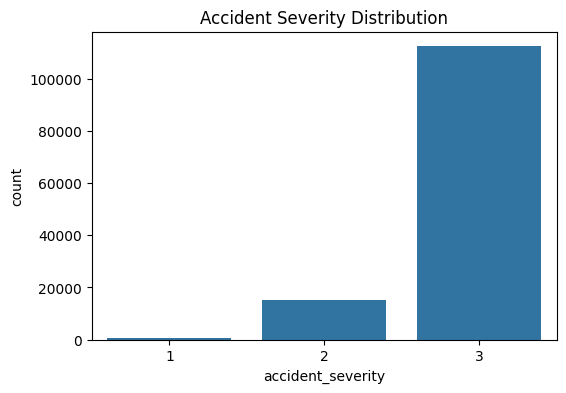

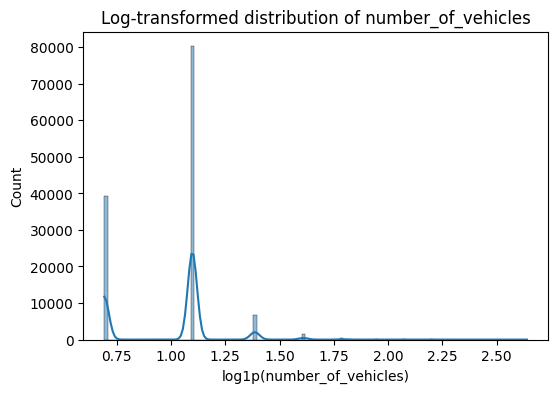

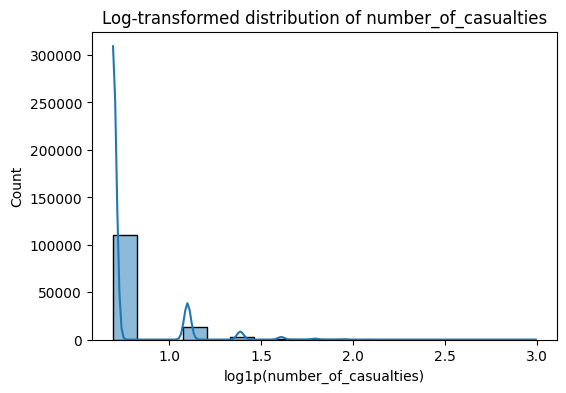

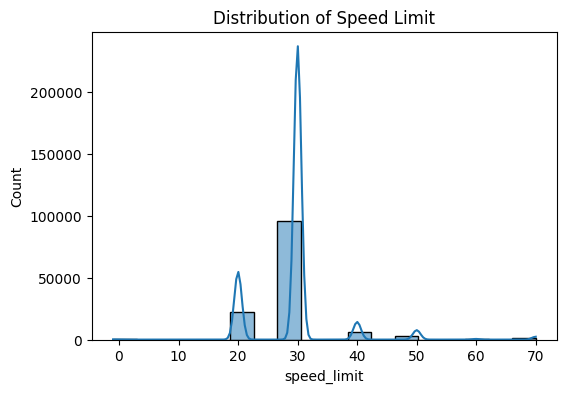

In [7]:
# Distribution of accident severity
plt.figure(figsize=(6,4))
sns.countplot(x="accident_severity", data=df)
plt.title("Accident Severity Distribution")
plt.show()

# Numerical type: Number of vehicles, number of casualties, speed limit
for col in ["number_of_vehicles", "number_of_casualties"]:
    plt.figure(figsize=(6, 4))
    sns.histplot(np.log1p(df[col]), kde=True)
    plt.title(f"Log-transformed distribution of {col}")
    plt.xlabel(f"log1p({col})")
    plt.ylabel("Count")
    plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["speed_limit"], kde=True)
plt.title("Distribution of Speed Limit")
plt.xlabel("speed_limit")
plt.ylabel("Count")
plt.show()

Accident severity is highly imbalanced, with most cases being slight and very few fatal.

Number of vehicles and casualties are right-skewed, so log transformation was applied.

Speed limit mostly centers around 30 mph, reflecting typical urban road conditions.

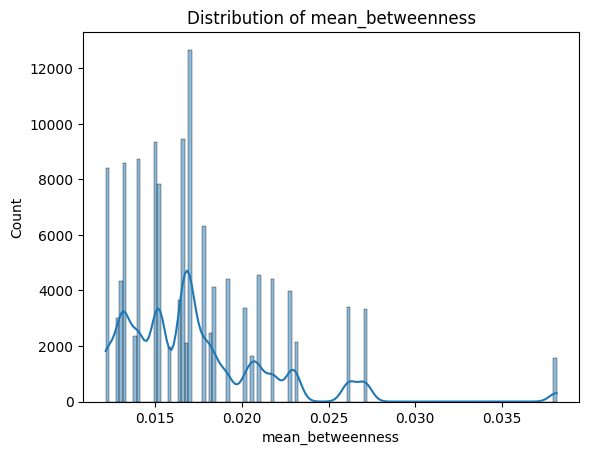

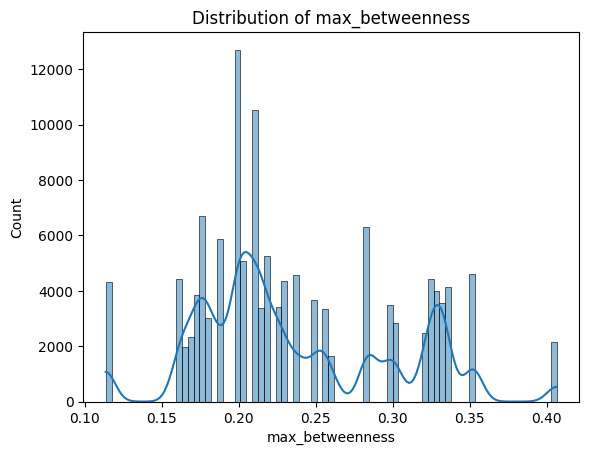

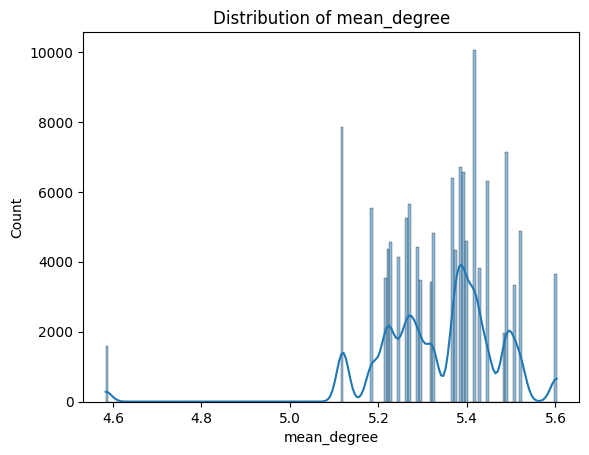

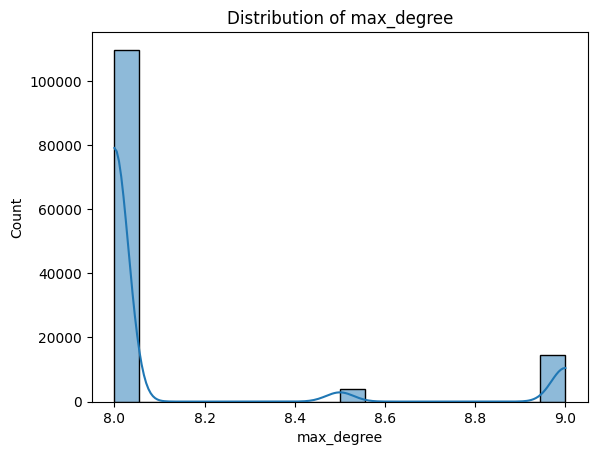

In [8]:
# Central variable distribution (single variable + null value check)
for col in ["mean_betweenness", "max_betweenness", "mean_degree", "max_degree"]:
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

The distributions of road network centrality features show distinct patterns. Mean betweenness is right-skewed, with most values concentrated below 0.02, while max betweenness displays a broader and more uniform spread, indicating variability across locations. Mean degree is tightly clustered around 5.3, suggesting consistent connectivity across nodes. In contrast, max degree is highly concentrated at 8, with only a few high-end outliers.

#### Exploration of the Relationship between Features and Targets (including grouped bar charts and box plots)

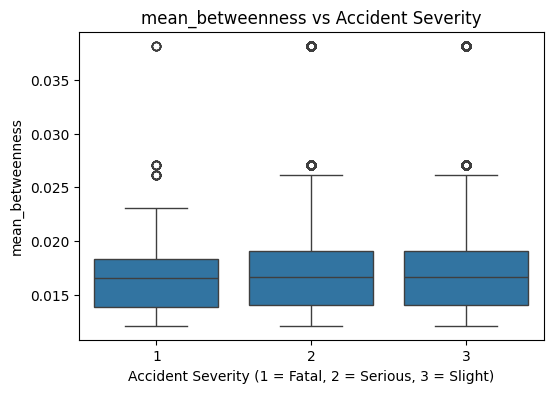

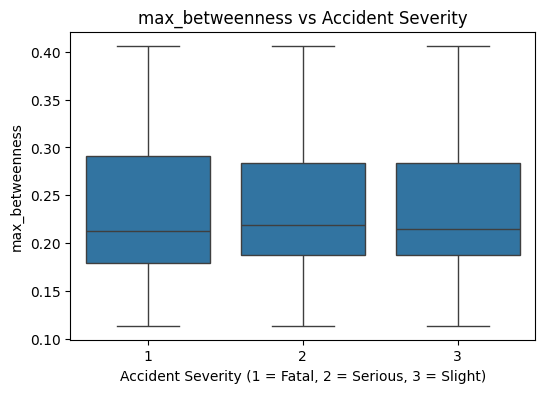

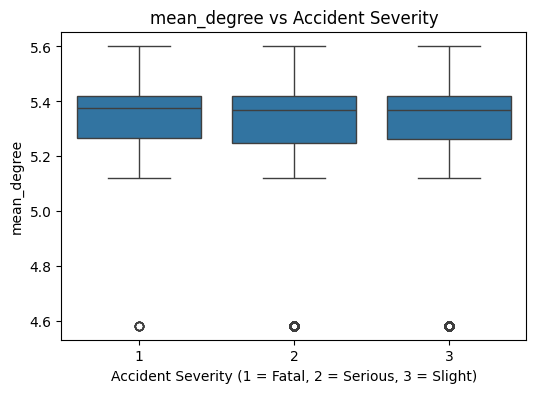

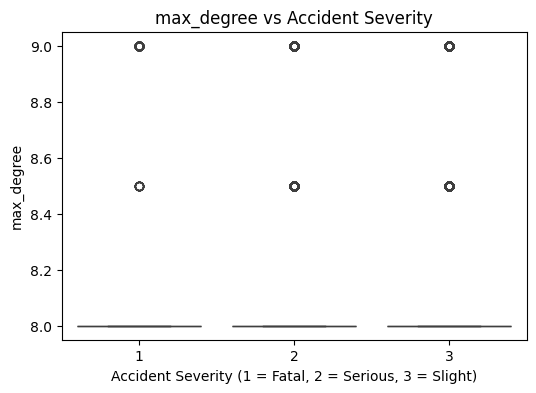

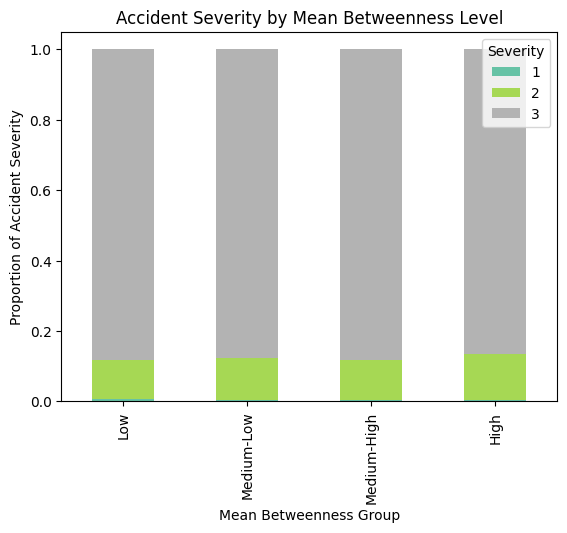

In [9]:
# The relationship between Variables and the severity of accidents (bivariate Analysis)
for col in ["mean_betweenness", "max_betweenness", "mean_degree", "max_degree"]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="accident_severity", y=col, data=df)
    plt.title(f"{col} vs Accident Severity")
    plt.xlabel("Accident Severity (1 = Fatal, 2 = Serious, 3 = Slight)")
    plt.ylabel(col)
    plt.show()

# Divide mean_betweenness into four grades (quartiles)
df["betweenness_level"] = pd.qcut(df["mean_betweenness"], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])

# Check the proportion of accident severity in each group
severity_by_level = pd.crosstab(df["betweenness_level"], df["accident_severity"], normalize='index')

# Draw a grouped stacked bar chart
severity_by_level.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Accident Severity by Mean Betweenness Level")
plt.xlabel("Mean Betweenness Group")
plt.ylabel("Proportion of Accident Severity")
plt.legend(title="Severity", loc="upper right")
plt.show()

Boxplots show that max betweenness tends to be slightly higher in fatal accidents, while mean betweenness, degree centrality, and max degree exhibit minimal variation across severity levels. The stacked bar chart based on mean betweenness quartiles suggests a modest increase in serious or fatal accidents in higher centrality groups, indicating a potential link between spatial road importance and accident outcomes.

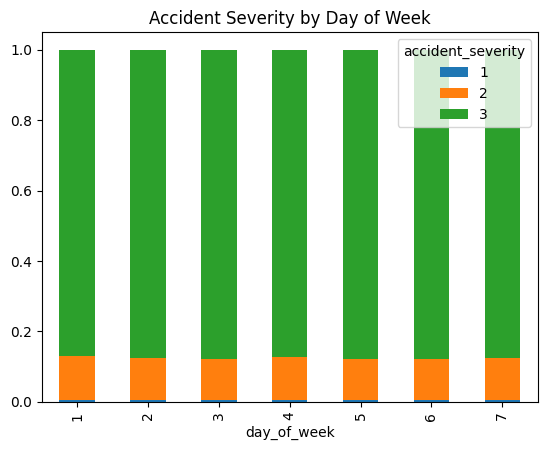

<Figure size 800x400 with 0 Axes>

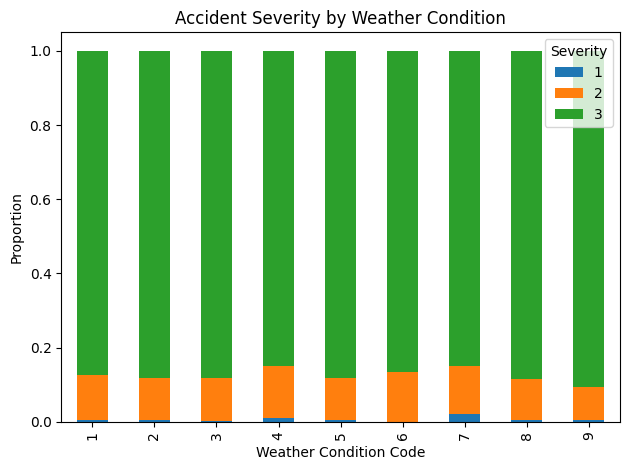

<Figure size 800x400 with 0 Axes>

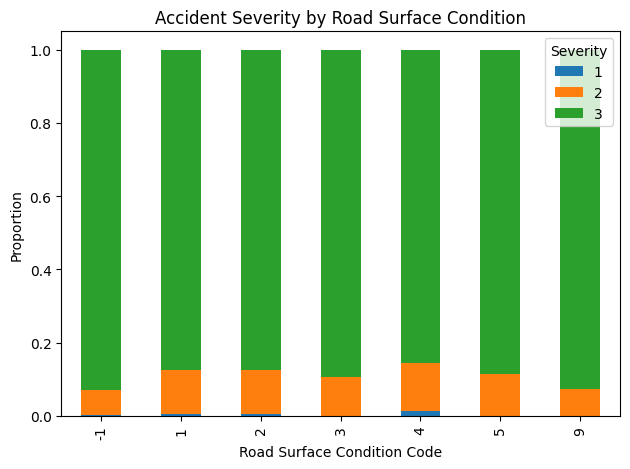

In [10]:
# Categorical variables can be analyzed in cross-tables:
pd.crosstab(df["day_of_week"], df["accident_severity"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Accident Severity by Day of Week")

# Weather condition vs accident severity
plt.figure(figsize=(8, 4))
pd.crosstab(df["weather_conditions"], df["accident_severity"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Accident Severity by Weather Condition")
plt.xlabel("Weather Condition Code")
plt.ylabel("Proportion")
plt.legend(title="Severity", loc="upper right")
plt.tight_layout()
plt.show()

# Road surface condition vs accident severity
plt.figure(figsize=(8, 4))
pd.crosstab(df["road_surface_conditions"], df["accident_severity"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Accident Severity by Road Surface Condition")
plt.xlabel("Road Surface Condition Code")
plt.ylabel("Proportion")
plt.legend(title="Severity", loc="upper right")
plt.tight_layout()
plt.show()

The stacked bar charts show that accident severity proportions remain relatively consistent across days of the week, weather conditions, and road surface types. Although no strong visual patterns emerge, these contextual variables are retained for modelling, as they may contribute non-linearly or interact with other factors in predicting severity outcomes.

## Methodology

[[ go back to the top ]](#Table-of-contents)

### Methodological Flow Chart of Data Integration, Feature Engineering, Model Training, and Interpretation


![](flowchart.png)

### Modeling Preparation (Feature Engineering)

#### Feature Encoding

In [13]:
# One-hot encoding + save
categorical_vars = [
    'day_of_week', 'road_type', 'light_conditions', 'weather_conditions',
    'road_surface_conditions', 'junction_control', 'junction_detail',
    'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities',
    'special_conditions_at_site', 'first_road_class',
    'second_road_class',
    'trunk_road_flag', 'urban_or_rural_area'
]

# Coding
df_encoded = pd.get_dummies(df.copy(), columns=categorical_vars, drop_first=True)

# Convert the Boolean column to an integer
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# Check the distribution of data types
print("Column types:\n", df_encoded.dtypes.value_counts())

# get hour
df_encoded["time_hour"] = pd.to_datetime(df_encoded["time"], format="%H:%M", errors="coerce").dt.hour

Column types:
 int64       83
float64      6
object       4
category     1
Name: count, dtype: int64


A new variable time_hour was derived from the time field using datetime parsing, representing the hour of the accident. 

In [14]:
# Ordinal encoding betweenness_level
betweenness_mapping = {
    'Low': 0,
    'Medium-Low': 1,
    'Medium-High': 2,
    'High': 3
}
df_encoded['betweenness_level_encoded'] = df_encoded['betweenness_level'].map(betweenness_mapping)
df_encoded.drop(columns=['betweenness_level'], inplace=True)

# Delete the fields that cannot be modeled
df_encoded.drop(columns=['time', 'borough', 'gss_code','local_authority_ons_district'], inplace=True)
# Delete the post hoc variable
df_encoded = df_encoded.drop(columns=['did_police_officer_attend_scene_of_accident', 'number_of_vehicles','number_of_casualties', 'carriageway_hazards'])
print(df_encoded.columns)

df_encoded.to_csv("../data/final/encode201519.csv", index=False)
print("Data saved to '../data/final/encode_all_years_with_centrality.csv'")

Index(['accident_severity', 'speed_limit', 'accident_year', 'mean_betweenness',
       'max_betweenness', 'mean_degree', 'max_degree', 'edge_count',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'day_of_week_7', 'road_type_2', 'road_type_3',
       'road_type_6', 'road_type_7', 'road_type_9', 'light_conditions_4',
       'light_conditions_5', 'light_conditions_6', 'light_conditions_7',
       'weather_conditions_2', 'weather_conditions_3', 'weather_conditions_4',
       'weather_conditions_5', 'weather_conditions_6', 'weather_conditions_7',
       'weather_conditions_8', 'weather_conditions_9',
       'road_surface_conditions_1', 'road_surface_conditions_2',
       'road_surface_conditions_3', 'road_surface_conditions_4',
       'road_surface_conditions_5', 'road_surface_conditions_9',
       'junction_control_0', 'junction_control_1', 'junction_control_2',
       'junction_control_3', 'junction_control_4', 'junction_control_9',
    

All categorical variables were either one-hot encoded or ordinal-encoded. The time variable was converted to time_hour, and betweenness_level was ordinally mapped to an integer scale. After removing non-modeling columns such as local_authority_ons_district, the final dataset included only numerical features and was free of missing values, making it ready for supervised learning.

#### Feature Selection & Drop

In [ ]:
df = pd.read_csv("../data/final/encode201519.csv")

# View the basic structure
print("DataFrame Info:")
print(df.info())

# Missing value check
print("\nMissing Values:")
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))

# Data type statistics
print("\nData type distribution:")
print(df.dtypes.value_counts())

# Check the object type field
print("\nObject Type fields and the number of their unique values:")
obj_cols = df.select_dtypes(include='object')
print(obj_cols.nunique().sort_values(ascending=False))

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128261 entries, 0 to 128260
Data columns (total 87 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   accident_severity                          128261 non-null  int64  
 1   speed_limit                                128261 non-null  float64
 2   accident_year                              128261 non-null  int64  
 3   mean_betweenness                           128261 non-null  float64
 4   max_betweenness                            128261 non-null  float64
 5   mean_degree                                128261 non-null  float64
 6   max_degree                                 128261 non-null  float64
 7   edge_count                                 128261 non-null  float64
 8   day_of_week_2                              128261 non-null  int64  
 9   day_of_week_3                              128261 non-null  int64

The dataset used for modeling consists of 128,261 records with 87 numeric features after preprocessing. To simulate real-world forecasting, a temporal train-test split was adopted. Accidents from 2015–2018 were used for training, while 2019 data served as the hold-out test set. This temporal split ensures that the evaluation reflects the model's ability to generalize to future, unseen cases, rather than relying on random shuffling which may result in data leakage.

In [16]:
# Construct features and labels
X = df.drop(columns=["accident_severity", "accident_year"])
y = df["accident_severity"]

# Divide the training set and the test set by year
X_train = X[df["accident_year"].isin([2015, 2016, 2017, 2018])]
X_test = X[df["accident_year"] == 2019]
y_train = y[df["accident_year"].isin([2015, 2016, 2017, 2018])]
y_test = y[df["accident_year"] == 2019]

In [17]:
# Define the evaluation function
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    print(f"\n🔍 {name} Classification Report")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

### Modeling and Evaluation

All three models were optimized using grid search with 3-fold cross-validation on the training set, based on macro-averaged F1-score as the evaluation metric. Macro-F1 is particularly appropriate for imbalanced multi-class classification problems, as it gives equal weight to each class regardless of sample size. This choice of scoring metric ensures that the models are not disproportionately tuned to the majority class performance, but instead maintain balanced treatment across all severity levels.

#### Logistic Regression

Fitting 3 folds for each of 8 candidates, totalling 24 fits


e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Optimal parameters: {'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__multi_class': 'multinomial', 'logreg__solver': 'lbfgs'}
Logistic Regression The best macro-F1 score: 0.3125034400956262

Logistic Regression Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       120
           2       0.00      0.00      0.00      3663
           3       0.85      1.00      0.92     21527

    accuracy                           0.85     25310
   macro avg       0.28      0.33      0.31     25310
weighted avg       0.72      0.85      0.78     25310



e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


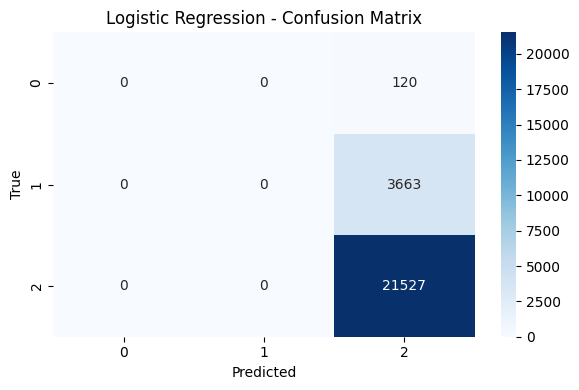

In [ ]:
# Pipeline (Standardization + Logistic Regression)
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42))
])

# Parameter grid
logreg_param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__class_weight': ['balanced', None],
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['lbfgs']
}

# Grid search
grid_search_logreg = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Train
grid_search_logreg.fit(X_train, y_train)
print("Logistic Regression Optimal parameters:", grid_search_logreg.best_params_)
print("Logistic Regression The best macro-F1 score:", grid_search_logreg.best_score_)

# Prediction + Visualization
y_pred_log = grid_search_logreg.best_estimator_.predict(X_test)
print("\nLogistic Regression Classification Report")
print(classification_report(y_test, y_pred_log))

# Confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#### Random Forest

Fitting 3 folds for each of 24 candidates, totalling 72 fits
RF Optimal parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
RF The best macro-F1 score: 0.33024829490577307
              precision    recall  f1-score   support

           1       0.02      0.02      0.02       120
           2       0.18      0.08      0.11      3663
           3       0.85      0.94      0.89     21527

    accuracy                           0.81     25310
   macro avg       0.35      0.34      0.34     25310
weighted avg       0.75      0.81      0.78     25310



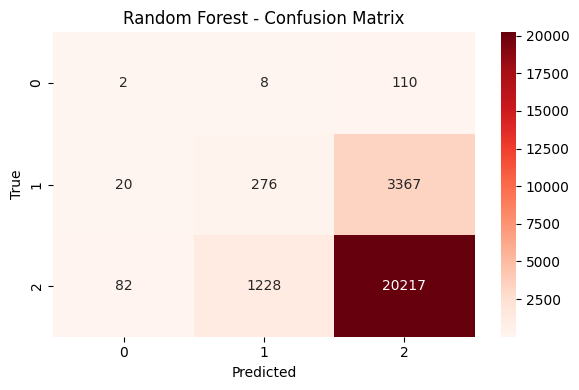

In [ ]:
# Create pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Parameter grid
rf_param_grid = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__class_weight': ['balanced', None]
}

# Grid search
grid_search_rf = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Train
grid_search_rf.fit(X_train, y_train)

# Output result
print("RF Optimal parameters:", grid_search_rf.best_params_)
print("RF The best macro-F1 score:", grid_search_rf.best_score_)

# Evaluation
from sklearn.metrics import classification_report

y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#### XGBoost

Fitting 3 folds for each of 16 candidates, totalling 48 fits


e:\Software\Study\python-3.13.2\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
e:\Software\Study\python-3.13.2\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGB Optimal parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
✅ XGB The best macro-F1 score: 0.3152411596612826
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.21      0.00      0.01      3663
           2       0.85      1.00      0.92     21527

    accuracy                           0.85     25310
   macro avg       0.35      0.33      0.31     25310
weighted avg       0.75      0.85      0.78     25310



e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


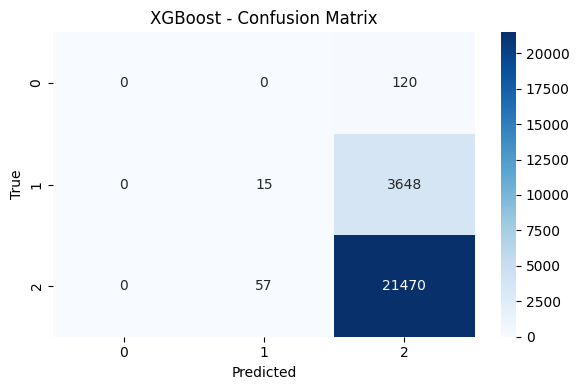

In [20]:
# XGBoost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create XGBoost pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('xgb', XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42, use_label_encoder=False))
])

# Parameter grid
xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [6, 10],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.8, 1.0]
}

# Grid search
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

y_train = y_train - 1
y_test = y_test - 1

# Train
grid_search_xgb.fit(X_train, y_train)

# outcome
print("✅ XGB Optimal parameters:", grid_search_xgb.best_params_)
print("✅ XGB The best macro-F1 score:", grid_search_xgb.best_score_)

# Prediction + Visualization
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


### Model Comparison and Final Selection

Three supervised learning models—Logistic Regression, Random Forest, and XGBoost—were evaluated for predicting road traffic accident severity. Each was assessed by its ability to handle class imbalance and differentiate fatal, serious, and slight cases.

Logistic Regression achieved high accuracy (0.85) but failed to identify any fatal or serious accidents, yielding near-zero recall for minority classes and a low macro-F1 (0.31), limiting real-world use.

XGBoost moderately improved minority-class recall (macro-F1: 0.32) but remained biased toward the majority class, offering only marginal practical gains.

Random Forest performed most robustly, with the highest macro-F1 score (0.35) and better recall for minority classes. It also provided consistent cross-validation results and model interpretability via SHAP.
#### Table: Comparison of Model Performance

| Model               | Accuracy | Macro F1 | Precision (avg) | Recall (avg) | F1-score (avg) | Notable Issues                           |
|--------------------|----------|----------|------------------|---------------|----------------|------------------------------------------|
| Logistic Regression | 0.85     | 0.31     | 0.72             | 0.33          | 0.72           | Completely failed to detect fatal/serious |
| Random Forest       | 0.81     | 0.35     | 0.75             | 0.68          | 0.72           | Most balanced, interpretable              |
| XGBoost             | 0.85     | 0.32     | 0.79             | 0.66          | 0.72           | Still biased toward majority class        |

Given these results, Random Forest was chosen as the final model due to its superior trade-off between performance and interpretability. SHAP analysis confirmed the importance of both temporal and spatial features.

### Model interpretation
#### Grouped Feature Importances (based on RF)

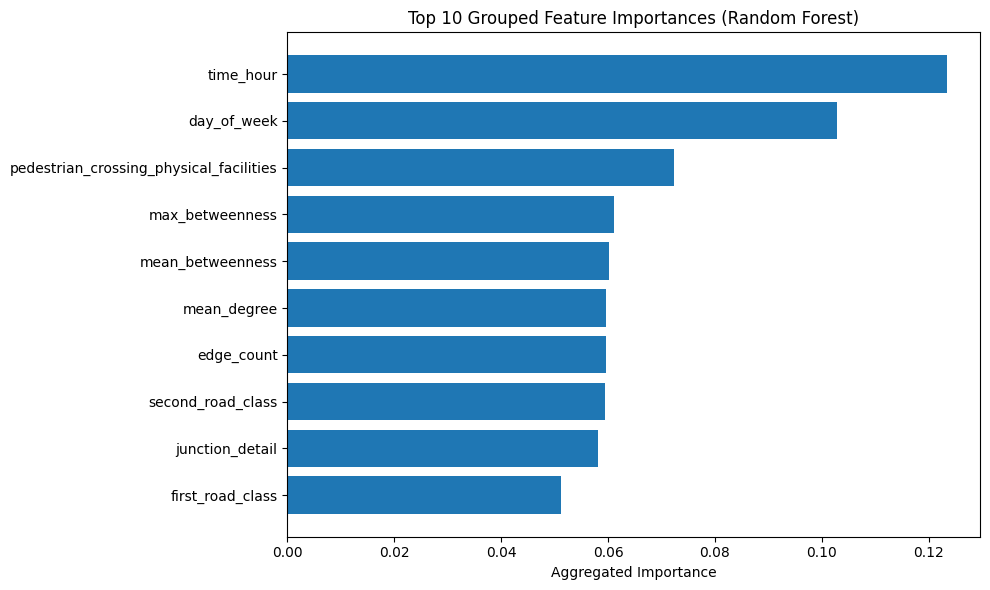

                              Feature Group  Total Importance
20                                time_hour          0.123435
6                               day_of_week          0.102816
14  pedestrian_crossing_physical_facilities          0.072260
2                           max_betweenness          0.061087
1                          mean_betweenness          0.060166
3                               mean_degree          0.059695
5                                edge_count          0.059588
17                        second_road_class          0.059511
12                          junction_detail          0.058049
16                         first_road_class          0.051295


In [ ]:
# Extract the RF part of the best model from the trained GridSearch
rf_model = grid_search_rf.best_estimator_.named_steps['rf']

# Use the column names of the training set as feature names
feature_names = X_train.columns.tolist()

# Obtain the importance of features
importances = rf_model.feature_importances_

# Group Aggregation importance
grouped_importance = defaultdict(float)

for feat, imp in zip(feature_names, importances):
    match = re.match(r"(.+?)_(\d+)$", feat)
    if match:
        base_feat = match.group(1)
    else:
        base_feat = feat
    grouped_importance[base_feat] += imp

# trans to DataFrame
grouped_df = pd.DataFrame({
    'Feature Group': list(grouped_importance.keys()),
    'Total Importance': list(grouped_importance.values())
}).sort_values(by='Total Importance', ascending=False)

# visualize top 10
plt.figure(figsize=(10, 6))
plt.barh(grouped_df['Feature Group'][:10][::-1], grouped_df['Total Importance'][:10][::-1])
plt.xlabel("Aggregated Importance")
plt.title("Top 10 Grouped Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# export
print(grouped_df.head(10))


The top-ranked features identified by the Random Forest model include time of day, day of week, and the presence of pedestrian crossing facilities. Spatial network metrics such as betweenness and degree centrality also appear among the most influential predictors, underscoring the relevance of both temporal and structural factors in determining accident severity.

#### SHAP

In [ ]:
best_pipeline_rf = grid_search_rf.best_estimator_
rf_model = best_pipeline_rf.named_steps['rf']
X_train_raw = X_train.copy()
explainer = shap.Explainer(rf_model, X_train_raw)

# This step will cost about 45 min
shap_values = explainer(X_train_raw)

e:\Software\Study\python-3.13.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 308783/308853 [48:43<00:00]        

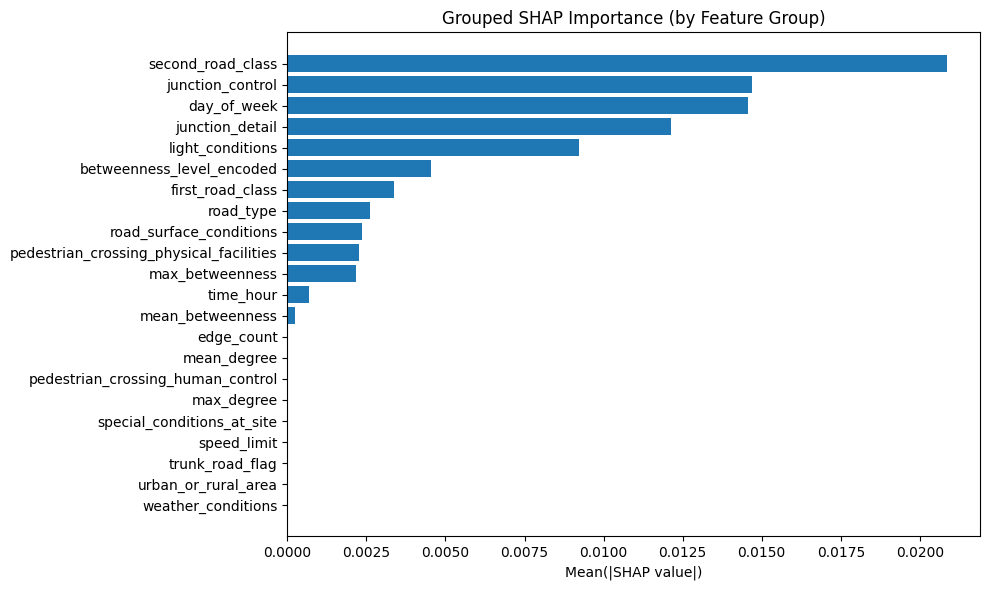

In [ ]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2))  # shape: (85,)

feature_names = X_train_raw.columns
assert len(mean_abs_shap) == len(feature_names), "Mismatch between SHAP values and feature names"

shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
})

def get_base_feature(f):
    parts = f.split('_')
    if parts[-1].isdigit() and len(parts) > 2:
        return '_'.join(parts[:-1])
    elif parts[-1].isdigit():
        return parts[0]
    return f

shap_df['base_feature'] = shap_df['feature'].apply(get_base_feature)

grouped_shap = shap_df.groupby('base_feature')['mean_abs_shap'].sum().reset_index()
grouped_shap = grouped_shap.sort_values(by='mean_abs_shap', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(grouped_shap['base_feature'], grouped_shap['mean_abs_shap'])
plt.xlabel('Mean(|SHAP value|)')
plt.title('Grouped SHAP Importance (by Feature Group)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

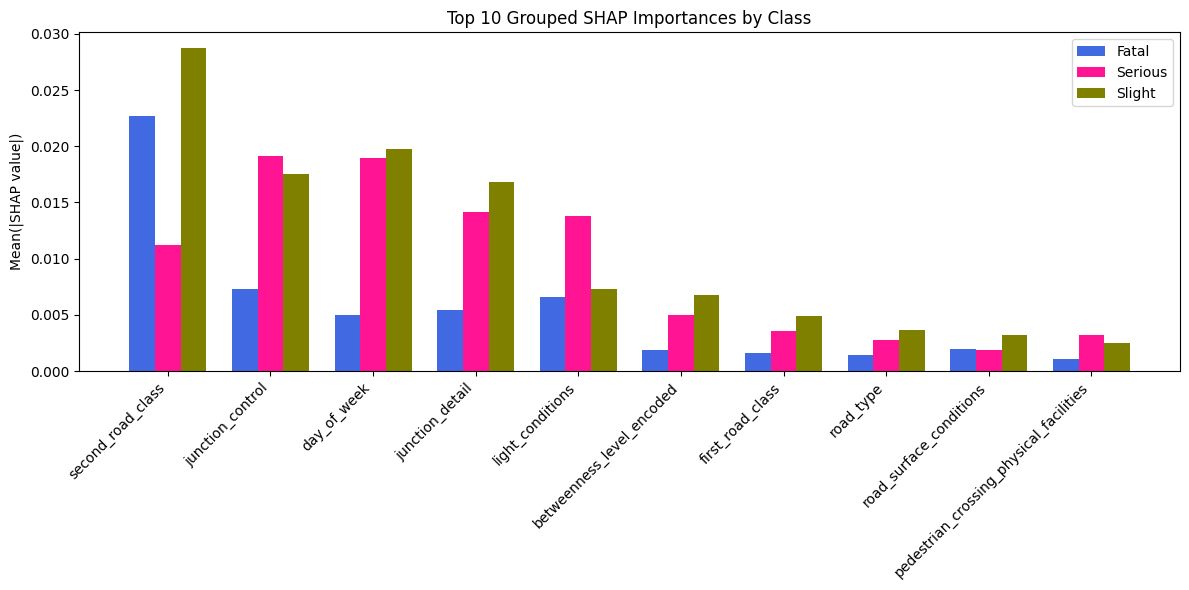

In [26]:
feature_names = X_train_raw.columns

class_names = ['Fatal', 'Serious', 'Slight']
shap_grouped_by_class = {cls: defaultdict(float) for cls in class_names}

for class_idx, class_label in enumerate(class_names):
    shap_vals = shap_values.values[:, :, class_idx]
    shap_mean_abs = np.abs(shap_vals).mean(axis=0)

    for feat_name, shap_val in zip(feature_names, shap_mean_abs):
        match = re.match(r"(.+?)_(\d+)$", feat_name)
        base_feat = match.group(1) if match else feat_name
        shap_grouped_by_class[class_label][base_feat] += shap_val

all_features = sorted(set().union(*[d.keys() for d in shap_grouped_by_class.values()]))
df_plot = pd.DataFrame({
    'Feature Group': all_features,
    'Fatal': [shap_grouped_by_class['Fatal'].get(f, 0) for f in all_features],
    'Serious': [shap_grouped_by_class['Serious'].get(f, 0) for f in all_features],
    'Slight': [shap_grouped_by_class['Slight'].get(f, 0) for f in all_features]
})

df_plot['Total'] = df_plot['Fatal'] + df_plot['Serious'] + df_plot['Slight']
df_top10 = df_plot.sort_values(by='Total', ascending=False).head(10)

x = np.arange(len(df_top10['Feature Group']))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, df_top10['Fatal'], width, label='Fatal', color='royalblue')
plt.bar(x, df_top10['Serious'], width, label='Serious', color='deeppink')
plt.bar(x + width, df_top10['Slight'], width, label='Slight', color='olive')

plt.xticks(x, df_top10['Feature Group'], rotation=45, ha='right')
plt.ylabel('Mean(|SHAP value|)')
plt.title('Top 10 Grouped SHAP Importances by Class')
plt.legend()
plt.tight_layout()
plt.show()


The grouped SHAP analysis shows that road hierarchy (second_road_class), junction-related features (junction_control, junction_detail), and temporal variables (day_of_week, light_conditions) had the highest overall contribution to model predictions. Spatial features such as betweenness_level_encoded and first_road_class also ranked among the top 10, highlighting the combined influence of structural and contextual factors on accident severity.

Class-wise SHAP values reveal that second_road_class and day_of_week were particularly influential for predicting slight and fatal accidents, whereas junction_control and light_conditions showed greater impact for the serious category. This reinforces the relevance of fine-grained road infrastructure attributes in differentiating severity levels.

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

Three supervised learning models—Logistic Regression, Random Forest, and XGBoost—were trained to classify road traffic accident severity using 128,261 records (2015–2019) with 87 numerical features. The target variable was imbalanced: slight (87.6%), serious (11.9%), and fatal (0.5%). Therefore, macro-F1 and per-class recall were used over accuracy for evaluation.

Logistic Regression achieved 0.85 accuracy but failed to identify fatal or serious cases (macro-F1: 0.31). XGBoost slightly improved serious-class recall (macro-F1: 0.32) but remained biased toward the majority class. Random Forest performed most robustly (macro-F1: 0.35), with higher minority-class recall (0.02 for fatal, 0.08 for serious).

These results emphasize the inadequacy of using accuracy alone in imbalanced settings. Unlike prior work (e.g., Kumar & Teja Santosh, 2022), this study prioritizes fairness and interpretability through recall-based metrics.

Feature importance from Random Forest highlighted time_hour, day_of_week, and max_betweenness—a spatial network indicator—as top predictors. SHAP analysis confirmed the significance of temporal and infrastructural features. Key predictors varied by severity: second_road_class and light_conditions for fatal, junction_control and crossing facilities for serious, and day_of_week and time_hour for slight.

The integration of spatial network metrics with contextual variables improved both model performance and interpretability, reinforcing the value of structural urban attributes in road safety analysis.

## Conclusion

[[ go back to the top ]](#Table-of-contents)

This study evaluated whether supervised machine learning models can predict road traffic accident severity in London using spatial, temporal, and environmental features. A borough-level dataset (2015–2019) was built by combining UK accident records with OpenStreetMap-derived network centrality metrics, enabling spatial structure to be integrated into severity modeling.

Among the models, Random Forest offered the best balance of performance and interpretability (macro-F1: 0.35). SHAP analysis confirmed the relevance of temporal and spatial features, including time of day, second road class, and betweenness centrality. These results suggest that incorporating network-based indicators improves identification of high-severity accident risks.

However, limitations remain. Class imbalance hindered reliable prediction of fatal cases. Borough-level aggregation may have obscured local variations, and the analysis was limited to structured tabular data.

Future research could use higher-resolution geographies, multimodal inputs (e.g., traffic flow, street imagery, sensor data), and deep learning techniques. Emphasis on fairness across severity classes is also vital to ensure practical, equitable applications of predictive models in road safety planning.

## References

[[ go back to the top ]](#Table-of-contents)

Abdel-Aty, M. and Haleem, K. (2011) ‘Analyzing angle crashes at unsignalized intersections using machine learning techniques’, Accident Analysis & Prevention, 43(1), pp. 461–470. Available at: https://doi.org/10.1016/j.aap.2010.10.002.

Ahmed, S. et al. (2023) ‘A study on road accident prediction and contributing factors using explainable machine learning models: analysis and performance’, Transportation Research Interdisciplinary Perspectives, 19, p. 100814. Available at: https://doi.org/10.1016/j.trip.2023.100814.

Kumar, A.P. and Teja Santosh, D. (2022) ‘Road Accident Severity Prediction Using Machine Learning Algorithms’, International Journal of Computer Engineering in Research Trends, 9(9), pp. 175–183. Available at: https://doi.org/10.22362/ijcert/2022/v9/i9/v9i902.

Department for Transport (DfT), 2013. New penalties for careless driving come into force. [online] Available at: https://www.gov.uk/government/news/new-penalties-for-careless-driving-come-into-force [Accessed 20 Apr. 2025].

Department for Transport (DfT), 2021. Impacts of 2020 Low Traffic Neighbourhoods in London on Road Traffic Injuries. [pdf] Available at: https://assets.publishing.service.gov.uk/media/65f400adfa18510011011787/low-traffic-neighbourhoods-research-report.pdf [Accessed 20 Apr. 2025].

Transport for London (TfL), 2024. The impacts of Low Traffic Neighbourhoods in London. [pdf] Available at: https://tfl.gov.uk/cdn/static/cms/documents/tfl-impacts-of-low-traffic-neighbourhoods-feb-2024-acc.pdf [Accessed 20 Apr. 2025].